Machine learning capstone project - fx spot prediction

The goal is to create features that can help predict the bid price, using a lookback period of a few minutes.

Try to include the bid offer spread - from the benchmark model it seems volume is not an important feature so it is not a problem that i dont have this data point.

I took inspiration from : https://www.kaggle.com/kimy07/eurusd-15-minute-interval-price-prediction/notebook

Introduction
This notebook trains a LSTM model that predicts the bid price of EURUSD 15 minutes in the future by looking at last five hours of data. While there is no requirement for the input to be contiguous, it's been empirically observed that having the contiguous input does improve the accuracy of the model. I suspect that having day of the week and hour of the day as the features mitigates some of the seasonality and contiguousness problems.

Disclaimer: This exercise has been carried out using a small sample data which only contains 14880 samples (2015-12-29 00:00:00 to 2016-05-31 23:45:00) and lacks ASK prices. Which restricts the ability for the model to approach a better accuracy.

Improvements

To tune the model further, I would recommend having at least 5 years worth of data, have ASK price (so that you can compute the spread), and increasing the epoch to 3000.
Adding more cross-axial features. Such as spread.
If you are looking into classification approach (PASS, BUY, SELL), consider adding some technical indicators that is more sensitive to more recent data.
Consider adding non-numerical data, e.g. news, Tweets. The catch is that you have to get the data under one minute for trading, otherwise the news will be reflected before you even make a trade. If anybody knows how to get the news streamed really fast, please let me know.

Credits : Dave Y. Kim, Mahmoud Elsaftawy,

To run on EC2:
Enter the repo directory: cd aind2-cnn
Activate the new environment: source activate aind2
Start Jupyter: jupyter notebook --ip=0.0.0.0 --no-browser
Find this line in output and copy url to browser: 
Copy/paste this URL into your browser when you connect for the first time to login with a token: 
http://0.0.0.0:8888/?token=3156e...

change the 0.0.0.0 with EC2 IP.

you should see the checked out repository

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from subprocess import check_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [54]:
import pypyodbc
display(HTML("""<script>
  
    $('.ctb_hideshow').toggle();
    
    </script>
 """))
    

In [3]:
# get data from mongodb
import io
import pymongo
from pymongo import MongoClient
import datetime

#client = MongoClient(connect=False) #Makes it "good enough" for our multi-threaded use case. 

# mng_client = pymongo.MongoClient('localhost', 27017)
# mng_db = mng_client['fx_prediction'] # Replace mongo db name
# collection_name = 'fx_tick_data_typed' # Replace mongo db table name
# db = mng_db[collection_name]

#print(db.count())
#min_date = datetime.datetime(2016, 1, 1, 0)
#max_date = datetime.datetime(2016, 12, 1, 0)
min_date = "1Jan16"
max_date = "1Feb16"

#https://bitbucket.org/djcbeach/monary/wiki/Home use to speed up

In [4]:
simname = "mine"

In [5]:
print(min_date)
print(max_date)

1Jan16
1Feb16


In [48]:
# # each of these is a stage in the pipeline - match, project, group, project.

# cursor_group = db.aggregate(
#    [
      
#        {"$match":{
#            "date": {
#                "$gte": min_date
#                , "$lte": max_date
#            }
#        }           
#        },
       
#        {
#            "$project": {
#                "_id" : 0
#                , "bo_spread": {"$subtract": ["$ask", "$bid"]}
#                , "bid": 1
#                , "ask": 1
#                , "date": 1
               
#            }
#        },
       
       
#        {
#         "$group" : {
#            #"_id" : "null",
#            "_id": {
#                "dateAgg": { "$dateToString": { "format": "%G/%m/%d %H:%M", "date": "$date" } }
#                },
#            #"high": { "$sum": { "$multiply": [ "$price", "$quantity" ] } },
#             "dateSample": {"$first": "$date"},
#             "high": { "$max": "$bid"},
#             "low": { "$min": "$bid"},
#             "open": { "$first": "$bid"},
#             "close": { "$last": "$bid"},
#            "avg_bo_spread": { "$avg": "$bo_spread" },
#            "max_bo_spread": { "$max": "$bo_spread" },
#            "min_bo_spread": { "$min": "$bo_spread" },
#            "count": { "$sum": 1 }
#         }
#       },
       
#        {
#            "$project": {
#                "_id" : 0
#                , "date": "$dateSample"
#                , "high": 1
#                , "low": 1
#                , "open": 1
#                , "close": 1
#                , "avg_bo_spread": 1
#                , "max_bo_spread": 1
#                , "min_bo_spread": 1
#                , "count": 1
#            }
#        }
       
#    ], allowDiskUse=True
# )


In [49]:
# cursor_group = db.aggregate(
#    [
#       {"$match":{
#            "date": {
#                "$gte": min_date
#                , "$lte": max_date
#            }
#        }           
#        },
       
             
#        {
#         "$group" : {
#            #"_id" : "null",
#            "_id": {
#                #"month": {"$month": "$date"}, 
#                #"day"  : {"$dayOfMonth": "$date"}, 
#                #"year" : {"$year": "$date"},
#                "time": { "$dateToString": { "format": "%G/%m/%d %H:%M", "date": "$date" } }
#                #"date": { "$dateFromParts": {"year": "$date", "month": "$date", "day": "$date", "hour": "$date", "minute": "$date"}}
#                },
#            #"high": { "$sum": { "$multiply": [ "$price", "$quantity" ] } },
#             "high": { "$max": "$date"},
#             "low": { "$min": "$date"},                                
#            "count": { "$sum": 1 }
#         }
#       }
#    ], allowDiskUse=True
# )


In [6]:

strConnDef = "DRIVER={ODBC Driver 13 for SQL Server};SERVER=localhost,1433;DATABASE=kai_dw;uid=kai_ta;pwd=tenpen12"
def getQueryRaw(strQuery, params=None, strConn=strConnDef, commitOn=None):

    if commitOn is None:
        commitOn = False

    if params is None:
        params = []

    pypyodbc.lowercase = False
    conn = pypyodbc.connect(strConn)
    cursor = conn.cursor()
    cursor.execute(strQuery, params)

    if commitOn:
        conn.commit()
        return "sql insert was successful.", "sql insert was successful."
    try:
        rows = cursor.fetchall()
        #print("rows", rows)
        # print("PARAMS:", params)
        description = cursor.description
        conn.close()
        return rows, description
    except:
        # print("THE QUERY: " + strQuery) TODO: add query
        conn.close()
        raise ValueError("There was an error fetching a sql query. Make sure the index exists for your selected dates. THE PARAMS: ", params)




def getQueryDataframe(strQuery, params=None, strConn=strConnDef, columnMustAlwaysExist=None, commitOn=None):

    rows, cursorDescription = getQueryRaw(strQuery, params, strConn, commitOn)
    if commitOn:
        return "sql insert was successful."

    if len(rows) == 0:
        print("No rows were returned.")
        print("THE PARAMS: ", params)
        print("THE QUERY: " + strQuery)
        print("Rows length is zero. No records returned")

        if columnMustAlwaysExist is None:
            columnMustAlwaysExist = "Empty"

        columns = ["Information", columnMustAlwaysExist]
        rows = [
            ["No results were returned.", "There is no data."]
            , ["No results were returned.", "There is no data."]
        ]

    else:
        # bytes conversion needed because of the linux pypyodbc bug
        columns = [column[0].decode("cp1252") if type(column[0]) == bytes else column[0] for column in
                   cursorDescription]

    results = pd.DataFrame(data=rows, columns=columns)


    return results


In [102]:
str_query = """


select
    --distinct
    const.year, const.month, const.day, const.hour, const.weekday, round(const.minute/15,0) * 15
    , const.snaptime 'date'
    , const.bid_price
    , const.ask_price
    , const.ask_price - const.bid_price 'bo_spread'
	, max(const.bid_price) over (partition by const.year, const.month, const.day, const.hour, round(const.minute/15,0))'high'
	, min(const.bid_price) over (partition by const.year, const.month, const.day, const.hour, round(const.minute/15,0)) 'low'
    , avg(const.ask_price - const.bid_price) over (partition by const.year, const.month, const.day, const.hour, round(const.minute/15,0)) 'avg_bo_spread'
	--, min(const.snaptime) 'open_datetime'
	--, max(const.snaptime) 'close_datetime'
	, count(*) over (partition by const.year, const.month, const.day, const.hour, round(const.minute/15,0)) 'count'
    , first_value(const.bid_price) over (partition by const.year, const.month, const.day, const.hour, round(const.minute/15,0) order by const.snaptime) 'open'
    , last_value(const.bid_price) over (partition by const.year, const.month, const.day, const.hour, round(const.minute/15,0) order by const.snaptime) 'close'
from dbo.fx_spot_data_features const
where
    const.snaptime >= '"""+min_date+"""'
    and const.snaptime <= '"""+max_date+"""'
    
--group by const.year, const.month, const.day, const.hour, round(const.minute/15,0)
--order by const.year, const.month, const.day, const.hour, round(const.minute/15,0)
order by const.snaptime

"""
res = getQueryDataframe(str_query)
print(res.count())
res.head()

,year,month,day,hour,weekday,,date,bid_price,ask_price,bo_spread,high,low,avg_bo_spread,count,open,close
0,2016,1,3,17,1,0,2016-01-03 17:00:15.493,1.08701,1.08751,0.00050,1.08723,1.08661,0.000165,142,1.08701,1.08701
1,2016,1,3,17,1,0,2016-01-03 17:00:38.993,1.08703,1.08749,0.00046,1.08723,1.08661,0.000165,142,1.08701,1.08703
2,2016,1,3,17,1,0,2016-01-03 17:00:41.493,1.08713,1.08749,0.00036,1.08723,1.08661,0.000165,142,1.08701,1.08713
3,2016,1,3,17,1,0,2016-01-03 17:00:41.993,1.08713,1.08745,0.00032,1.08723,1.08661,0.000165,142,1.08701,1.08713
4,2016,1,3,17,1,0,2016-01-03 17:00:44.743,1.08703,1.08745,0.00042,1.08723,1.08661,0.000165,142,1.08701,1.08703


In [141]:
#cursor = list(cursor_group)
df_res =  pd.DataFrame(res)
df_res.set_index('date', inplace=True)
#df_res.rename(columns={"_id": "date"}, inplace=True)

KeyError: 'date'

In [143]:
df_res.to_csv("eurusd_features.csv")

In [3]:
df_res = pd.read_csv("data/eurusd_features.csv")
df_res.set_index('date', inplace=True)


In [5]:
# load kaggle reference dataset for comparison
#df_kaggle = pd.read_csv('data/bm_kaggle/EURUSD_15m_BID_sample.csv')
df_kaggle = pd.read_csv('data/bm_kaggle/EURUSD_15m_BID_01.01.2010-31.12.2016.csv')

# Rename bid OHLC columns
df_kaggle.rename(columns={'Time' : 'date', 'Open' : 'open', 'Close' : 'close', 
                   'High' : 'high', 'Low' : 'low', 'Close' : 'close', 'Volume' : 'volume'}, inplace=True)
df_kaggle['date'] = pd.to_datetime(df_kaggle['date'], infer_datetime_format=True)
df_kaggle.set_index('date', inplace=True)
df_kaggle = df_kaggle.astype(float)

simname = "bm_kaggle"

df_res = df_kaggle

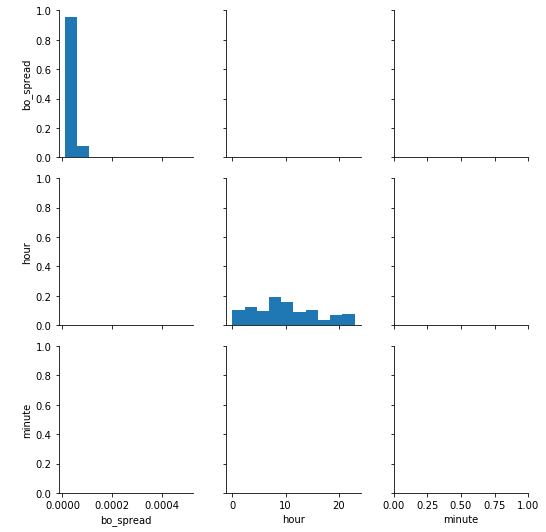

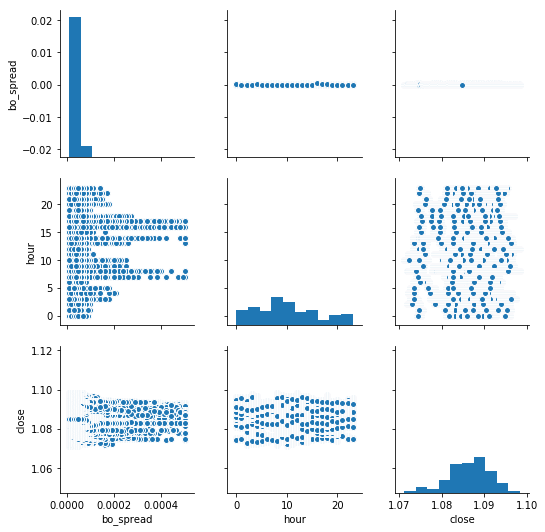

In [10]:
#df_res.date = pd.to_datetime(df_res.date.dateAgg, format='%Y%m%d %H:%M')
df_res.head()
sns.pairplot(df_res.loc[:,["bo_spread", "hour", "close"]])
plt.show()

In [12]:
#plt.savefig("test.png")
print(df_res.count())
print(df_res.index.min(), df_res.index.max())
df_res.head()

year             2081682
month            2081682
day              2081682
hour             2081682
weekday          2081682
Unnamed: 6       2081682
bid_price        2081682
ask_price        2081682
bo_spread        2081682
high             2081682
low              2081682
avg_bo_spread    2081682
count            2081682
open             2081682
close            2081682
avg_price        2081682
range            2081682
ohlc_price       2081682
oc_diff          2081682
period_return    2081682
pca              2081682
dtype: int64
2016-01-03 17:00:15.493 2016-01-31 23:59:41.170


,year,month,day,hour,weekday,Unnamed: 6,bid_price,ask_price,bo_spread,high,...,avg_bo_spread,count,open,close,avg_price,range,ohlc_price,oc_diff,period_return,pca
date,,,,,,,,,,,,,,,,,,,,,
2016-01-03 17:00:15.493,2016,1,3,17,1,0,1.08701,1.08751,0.00050,1.08723,...,0.000165,142,1.08701,1.08701,1.08692,0.00062,1.086965,0.00000,1.000000,-1322.240112
2016-01-03 17:00:38.993,2016,1,3,17,1,0,1.08703,1.08749,0.00046,1.08723,...,0.000165,142,1.08701,1.08703,1.08692,0.00062,1.086970,-0.00002,1.000018,-1322.160522
2016-01-03 17:00:41.493,2016,1,3,17,1,0,1.08713,1.08749,0.00036,1.08723,...,0.000165,142,1.08701,1.08713,1.08692,0.00062,1.086995,-0.00012,1.000110,-1322.161377
2016-01-03 17:00:41.993,2016,1,3,17,1,0,1.08713,1.08745,0.00032,1.08723,...,0.000165,142,1.08701,1.08713,1.08692,0.00062,1.086995,-0.00012,1.000110,-1322.161865
2016-01-03 17:00:44.743,2016,1,3,17,1,0,1.08703,1.08745,0.00042,1.08723,...,0.000165,142,1.08701,1.08703,1.08692,0.00062,1.086970,-0.00002,1.000018,-1322.161011


In [18]:
#df.drop(["vol"], axis=1, inplace=True)
df_res.columns

Index(['year', 'month', 'day', 'hour', 'weekday', 'Unnamed: 6', 'bid_price',
       'ask_price', 'bo_spread', 'high', 'low', 'avg_bo_spread', 'count',
       'open', 'close', 'avg_price', 'range', 'ohlc_price', 'oc_diff',
       'period_return', 'pca'],
      dtype='object')

In [19]:
df = df_res
# all these should refer to the price prediction period, so for tick it doesnt exist
#df['low'] = df.bid.min()
#df['high'] = df.bid.max()
#df['open'] = df.bid.iat[1]
#df['close'] = df.bid.iat[-1]

# to include seasonality as a feature
#df['hour'] = df.index.hour
#df['day']  = df.index.weekday
#df['week'] = df.index.week
#df['month'] = df.index.month

#df['momentum']  = df['volume'] * (df['open'] - df['close'])
df['avg_price'] = (df['low'] + df['high'])/2
df['range']     = df['high'] - df['low']
df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close'])/4
df['oc_diff']    = df['open'] - df['close']
#df['bo_spread'] = df.ask - df.bid
df['period_return'] = df.close / df.open

2081682


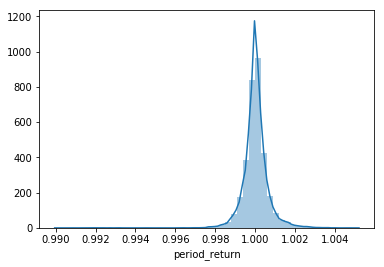

In [20]:
# create ohlc prices
df_res.head()
print(df.high.count())
sns.distplot(df.period_return)
plt.show()

In [164]:
#df.drop(["_id"], axis=1, inplace=True)
df.head()
#df.to_excel("df_res.xlsx")
import dill as pickle
with open(simname+'_fx_features.pkl', 'wb') as file:
    pickle.dump(df, file)

In [108]:
# Add PCA as a feature instead of for reducing the dimensionality. This improves the accuracy a bit.
from sklearn.decomposition import PCA

dataset = df.copy().values.astype('float32')
pca_features = df.columns.tolist()

pca = PCA(n_components=1)
df['pca'] = pca.fit_transform(dataset)

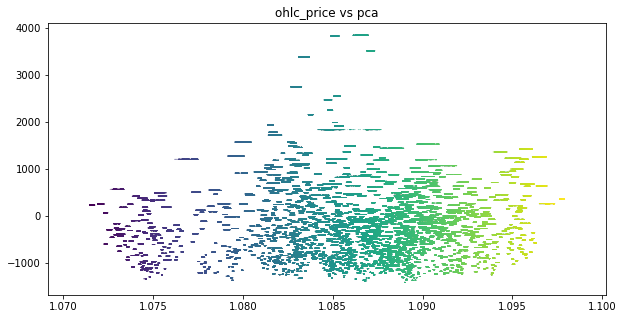

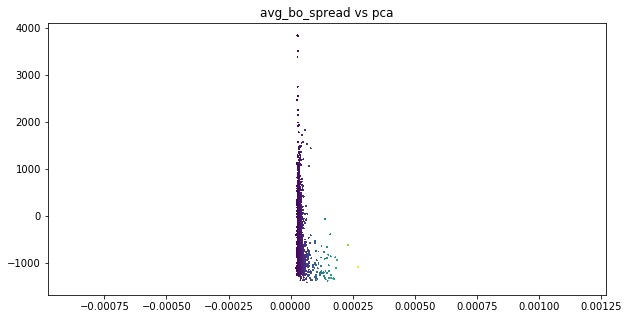

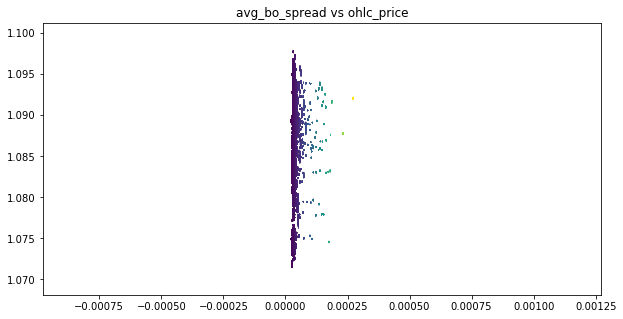

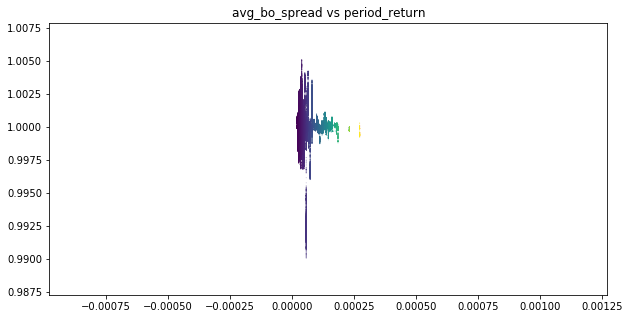

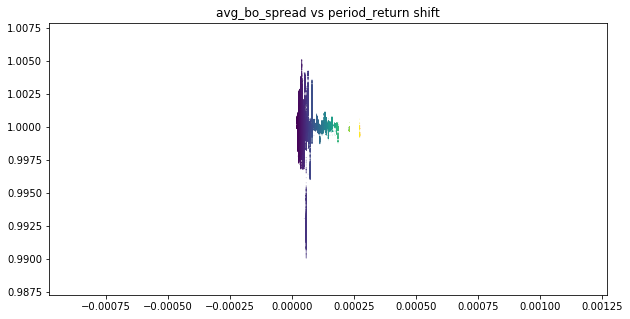

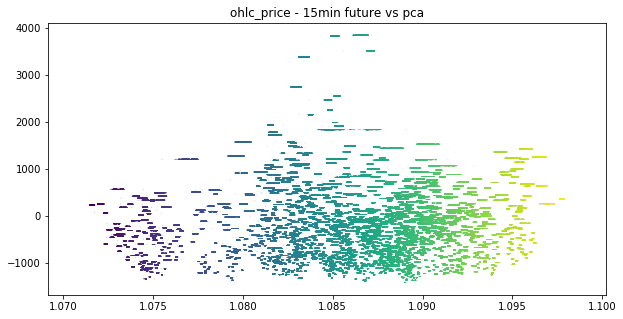

In [114]:
import matplotlib.colors as colors
import matplotlib.cm as cm
import pylab

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price vs pca')
plt.show()

if simname != "bm_kaggle":

    plt.figure(figsize=(10,5))
    norm = colors.Normalize(df['avg_bo_spread'].values.min(), df['avg_bo_spread'].values.max())
    color = cm.viridis(norm(df['avg_bo_spread'].values))
    plt.scatter(df['avg_bo_spread'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    plt.title('avg_bo_spread vs pca')
    plt.show()


    plt.figure(figsize=(10,5))
    norm = colors.Normalize(df['avg_bo_spread'].values.min(), df['avg_bo_spread'].values.max())
    color = cm.viridis(norm(df['avg_bo_spread'].values))
    plt.scatter(df['avg_bo_spread'].values, df['ohlc_price'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    plt.title('avg_bo_spread vs ohlc_price')
    plt.show()


    plt.figure(figsize=(10,5))
    norm = colors.Normalize(df['avg_bo_spread'].values.min(), df['avg_bo_spread'].values.max())
    color = cm.viridis(norm(df['avg_bo_spread'].values))
    plt.scatter(df['avg_bo_spread'].values, df['period_return'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    plt.title('avg_bo_spread vs period_return')
    plt.show()
    
    plt.figure(figsize=(10,5))
    norm = colors.Normalize(df['avg_bo_spread'].values.min(), df['avg_bo_spread'].values.max())
    color = cm.viridis(norm(df['avg_bo_spread'].values))
    plt.scatter(df['avg_bo_spread'].values, df['period_return'].shift().values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    plt.title('avg_bo_spread vs period_return shift')
    plt.show()
    
    plt.figure(figsize=(10,5))
    norm = colors.Normalize(df['bo_spread'].values.min(), df['bo_spread'].values.max())
    color = cm.viridis(norm(df['bo_spread'].values))
    plt.scatter(df['bo_spread'].values, df['period_return'].shift().values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
    plt.title('bo_spread vs period_return shift')
    plt.show()

#plt.figure(figsize=(10,5))
#norm = colors.Normalize(df['volume'].values.min(), df['volume'].values.max())
#color = cm.viridis(norm(df['volume'].values))
#plt.scatter(df['volume'].values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
#plt.title('volume vs pca')
#plt.show()

plt.figure(figsize=(10,5))
norm = colors.Normalize(df['ohlc_price'].values.min(), df['ohlc_price'].values.max())
color = cm.viridis(norm(df['ohlc_price'].values))
plt.scatter(df['ohlc_price'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
plt.title('ohlc_price - 15min future vs pca')
plt.show()

#plt.figure(figsize=(10,5))
#norm = colors.Normalize(df['volume'].values.min(), df['volume'].values.max())
#color = cm.viridis(norm(df['volume'].values))
#plt.scatter(df['volume'].shift().values, df['pca'].values, lw=0, c=color, cmap=pylab.cm.cool, alpha=0.3, s=1)
#plt.title('volume - 15min future vs pca')
#plt.show()

In [21]:
# this creates a training dataset for the model
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

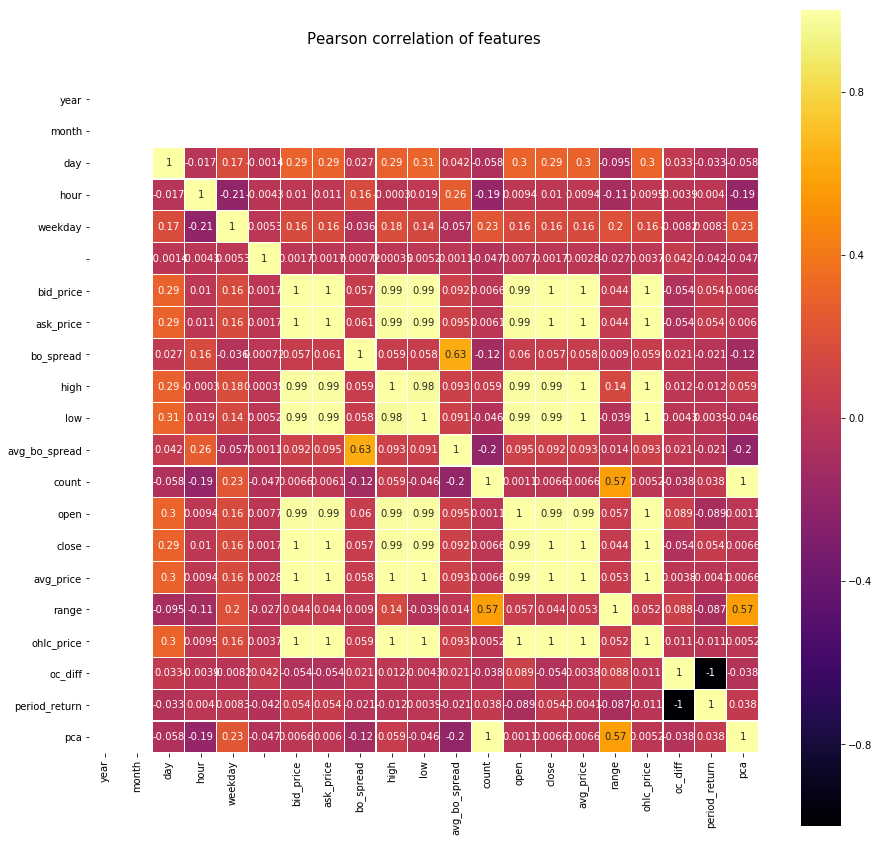

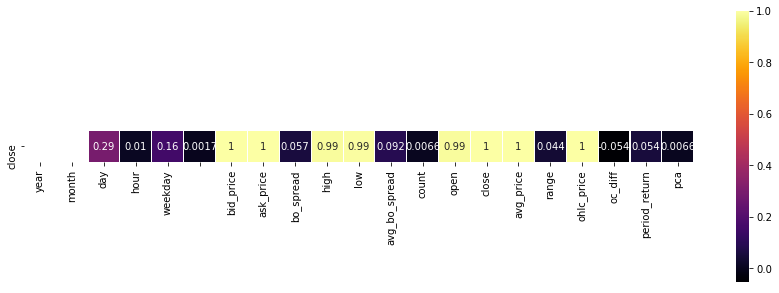

In [111]:
# check feature correlation, to see what correlates with the close price
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

plt.figure(figsize=(15,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'close'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [112]:
# create random forest regressor - random decision trees, like weak learner, ada boost
from sklearn.ensemble import RandomForestRegressor

# Scale and create datasets
target_index = df.columns.tolist().index('close')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=1)
y = y[:,target_index]
X = np.reshape(X, (X.shape[0], X.shape[2]))

In [113]:
# fit model
forest = RandomForestRegressor(n_estimators = 100)
forest = forest.fit(X, y)

KeyboardInterrupt: 

Feature ranking:
0. pca 19 (0.453368)
1. ask_price 7 (0.217941)
2. ohlc_price 16 (0.075821)
3. close 13 (0.069535)
4. period_return 18 (0.064586)
5. bid_price 6 (0.060840)
6. oc_diff 17 (0.057908)
7. month 1 (0.000000)
8. day 2 (0.000000)
9. hour 3 (0.000000)
10. weekday 4 (0.000000)
11.  5 (0.000000)
12. low 9 (0.000000)
13. high 8 (0.000000)
14. avg_bo_spread 10 (0.000000)
15. count 11 (0.000000)
16. open 12 (0.000000)
17. avg_price 14 (0.000000)
18. range 15 (0.000000)


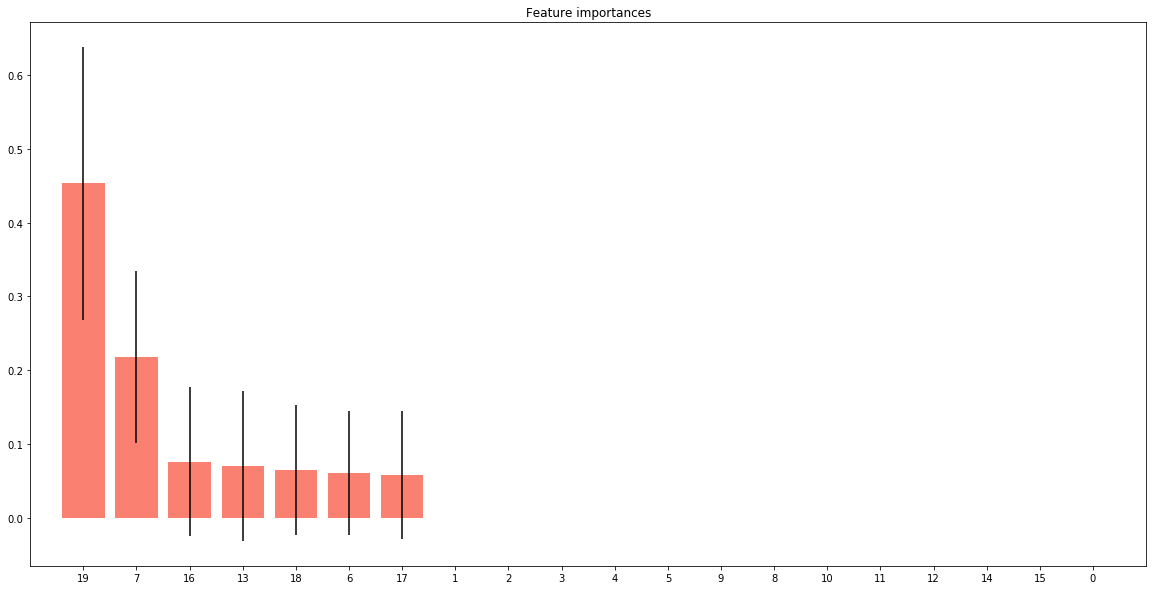

In [89]:
# find feature with best explanatory power to predict close price
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

column_list = df.columns.tolist()
print("Feature ranking:")
for f in range(X.shape[1]-1):
    print("%d. %s %d (%f)" % (f, column_list[indices[f]], indices[f], importances[indices[f]]))

# Plot the feature importances coming from the forest of decision trees
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="salmon", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [116]:
# plot close price, compare to low and high price
ax = df.plot(x=df.index, y='close', c='red', figsize=(40,10))
index = [str(item) for item in df.index]
plt.fill_between(x=index, y1='low',y2='high', data=df, alpha=0.4)
plt.show()

# plot first 200 entries 
p = df[:200].copy()
ax = p.plot(x=p.index, y='close', c='red', figsize=(40,10))
index = [str(item) for item in p.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('zoomed, first 200')
plt.show()

KeyboardInterrupt: 

In [32]:
# Scale and create datasets
target_index = df.columns.tolist().index('close')
high_index = df.columns.tolist().index('high')
low_index = df.columns.tolist().index('low')
dataset = df.values.astype('float32')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create y_scaler to inverse it later
y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = df['close'].values.astype('float32')
t_y = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y)
    
# Set look_back to 20 which is 5 hours (15min*20)
X, y = create_dataset(dataset, look_back=1)
y = y[:,target_index]

In [33]:
# Set training data size
# We have a large enough dataset. So divid into 98% training / 1%  development / 1% test sets
train_size = int(len(X) * 0.99)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense

# create a small LSTM network
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 20)             3360      
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 20)             3280      
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 10)             1240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 4)                 240       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total para

In [35]:

# Save the best weight during training.
simname = "bm_kaggle_4"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(simname + ".weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

# Fit
callbacks_list = [checkpoint]
%time history = model.fit(trainX, trainY, epochs=100, batch_size=10000, verbose=0, callbacks=callbacks_list, validation_split=0.1)

Epoch 00000: val_mean_squared_error improved from inf to 0.02140, saving model to bm_kaggle_4.weights.best.hdf5
Epoch 00001: val_mean_squared_error improved from 0.02140 to 0.00056, saving model to bm_kaggle_4.weights.best.hdf5
Epoch 00002: val_mean_squared_error improved from 0.00056 to 0.00035, saving model to bm_kaggle_4.weights.best.hdf5
Epoch 00003: val_mean_squared_error improved from 0.00035 to 0.00024, saving model to bm_kaggle_4.weights.best.hdf5
Epoch 00004: val_mean_squared_error improved from 0.00024 to 0.00011, saving model to bm_kaggle_4.weights.best.hdf5
Epoch 00005: val_mean_squared_error improved from 0.00011 to 0.00006, saving model to bm_kaggle_4.weights.best.hdf5
Epoch 00006: val_mean_squared_error improved from 0.00006 to 0.00005, saving model to bm_kaggle_4.weights.best.hdf5
Epoch 00007: val_mean_squared_error improved from 0.00005 to 0.00003, saving model to bm_kaggle_4.weights.best.hdf5
Epoch 00008: val_mean_squared_error did not improve
Epoch 00009: val_mean_sq

epoch 100


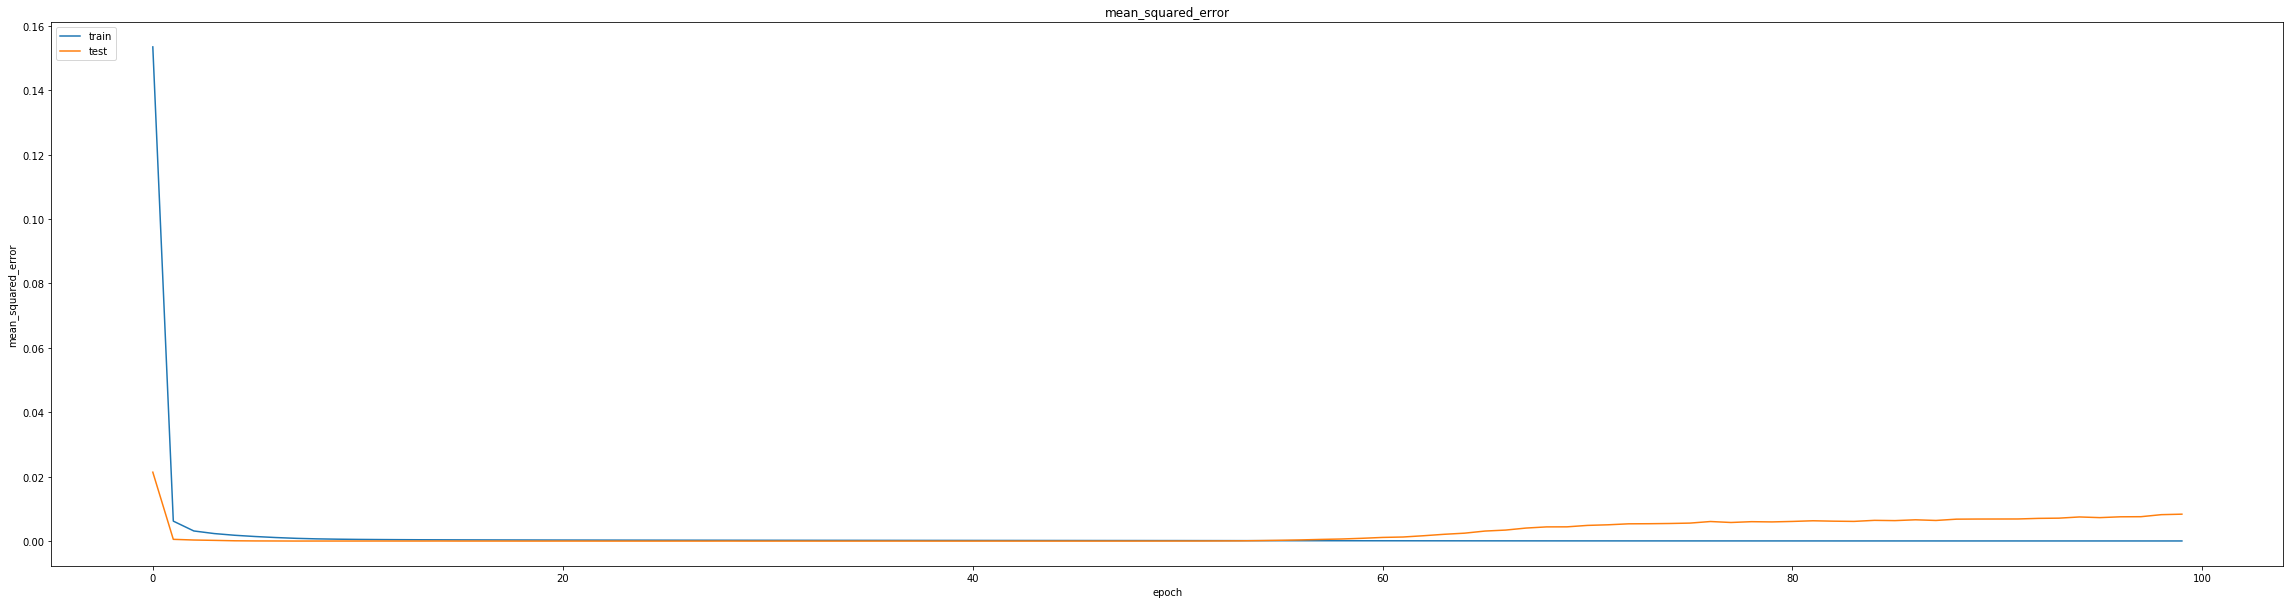

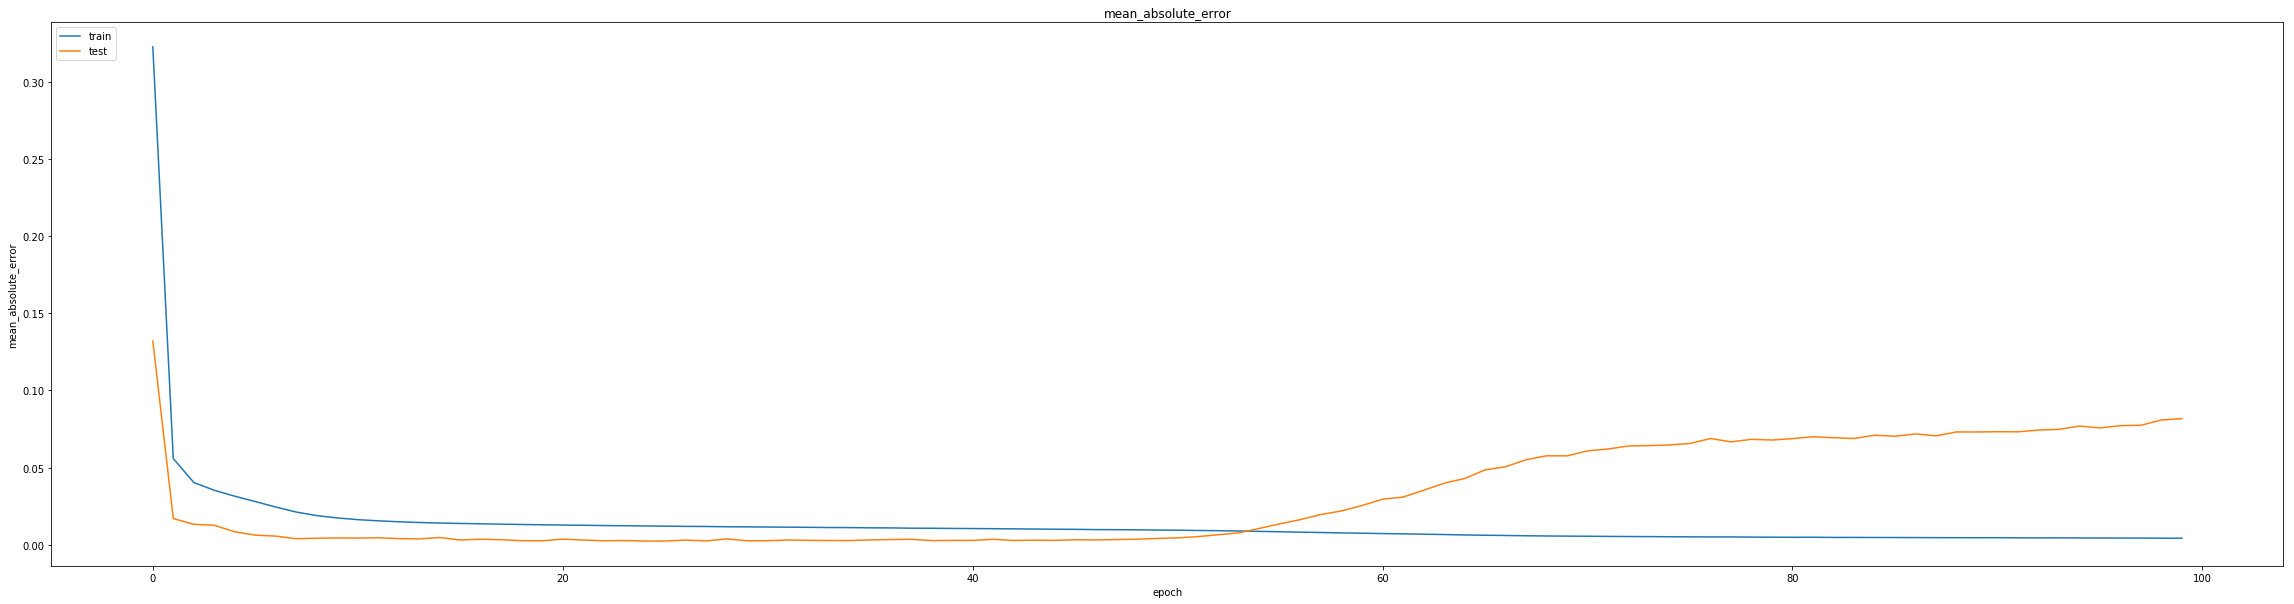

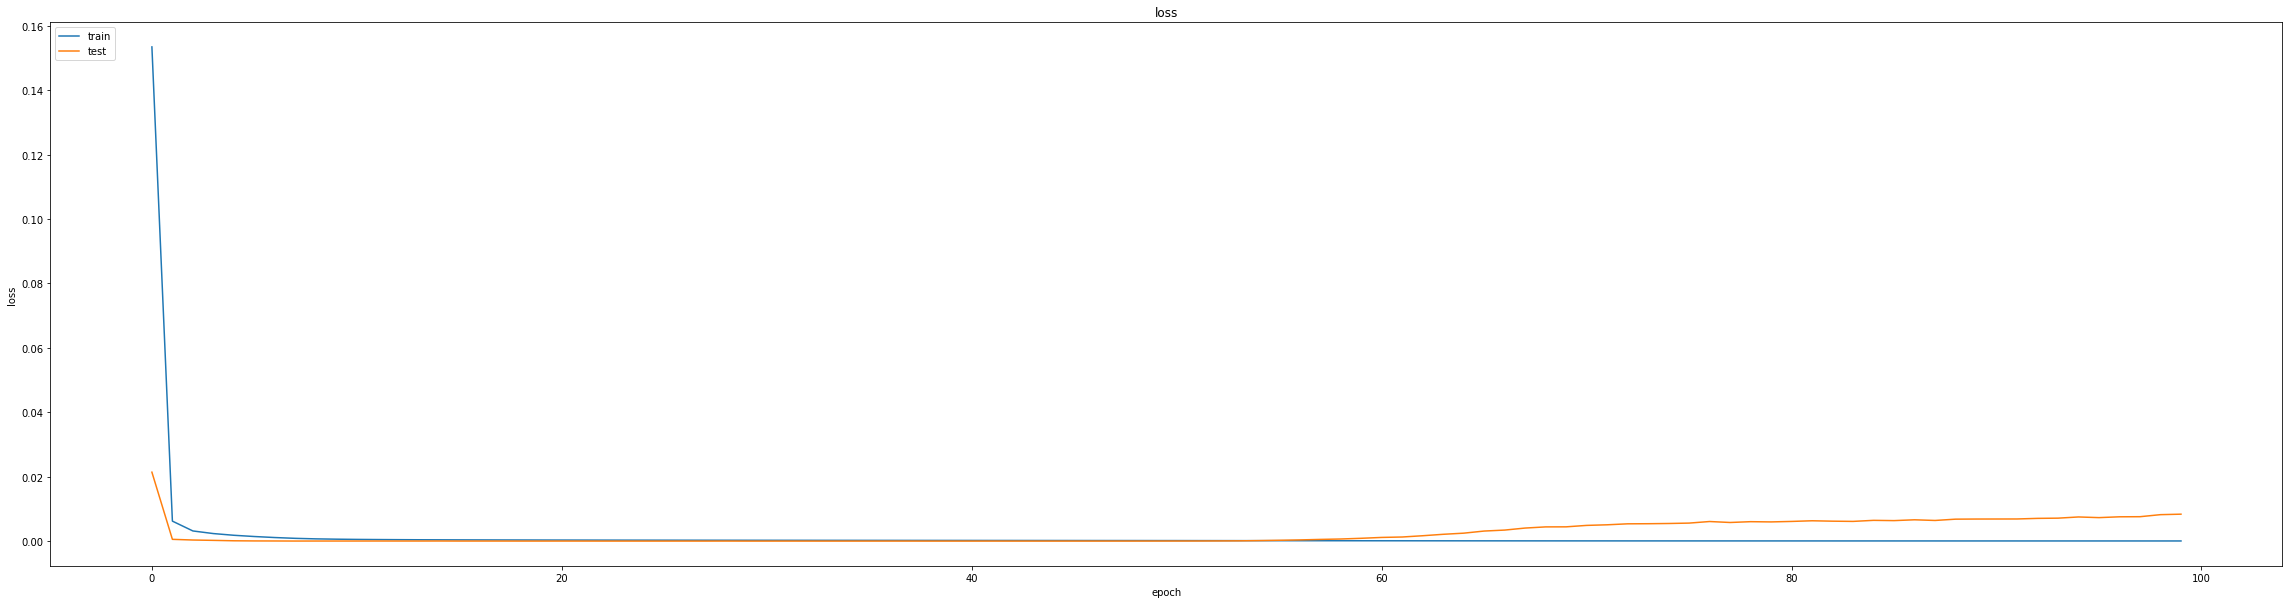

In [36]:
epoch = len(history.history['loss'])
print("epoch", epoch)
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [37]:
min(history.history['val_mean_absolute_error'])

0.0022660818189899888

As seen from the above, the model seems to have converged nicely, but the mean absolute error on the development data remains at ~0.003X which means the model is unusable in practice. Ideally, we want to get ~0.0005. Let's go back to the best weight, and decay the learning rate while retraining the model

In [38]:
# tune model by starting from best weights and rerunning with decaying learning rate
# Load the weight that worked the best
model.load_weights(simname+".weights.best.hdf5")
#epoch=60

# Train again with decaying learning rate
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, lr_decay]
history = model.fit(trainX, trainY, epochs=int(epoch/3), batch_size=10000, verbose=0, callbacks=callbacks_list, validation_split=0.1)

Epoch 00000: val_mean_squared_error improved from 0.00001 to 0.00001, saving model to bm_kaggle_4.weights.best.hdf5
Epoch 00001: val_mean_squared_error improved from 0.00001 to 0.00001, saving model to bm_kaggle_4.weights.best.hdf5
lr changed to 0.0009000000427477062
Epoch 00002: val_mean_squared_error did not improve
Epoch 00003: val_mean_squared_error did not improve
lr changed to 0.0008100000384729356
Epoch 00004: val_mean_squared_error did not improve
Epoch 00005: val_mean_squared_error did not improve
lr changed to 0.0007290000503417104
Epoch 00006: val_mean_squared_error did not improve
Epoch 00007: val_mean_squared_error did not improve
lr changed to 0.0006561000715009868
Epoch 00008: val_mean_squared_error did not improve
Epoch 00009: val_mean_squared_error did not improve
lr changed to 0.0005904900433961303
Epoch 00010: val_mean_squared_error did not improve
Epoch 00011: val_mean_squared_error improved from 0.00001 to 0.00001, saving model to bm_kaggle_4.weights.best.hdf5
lr c

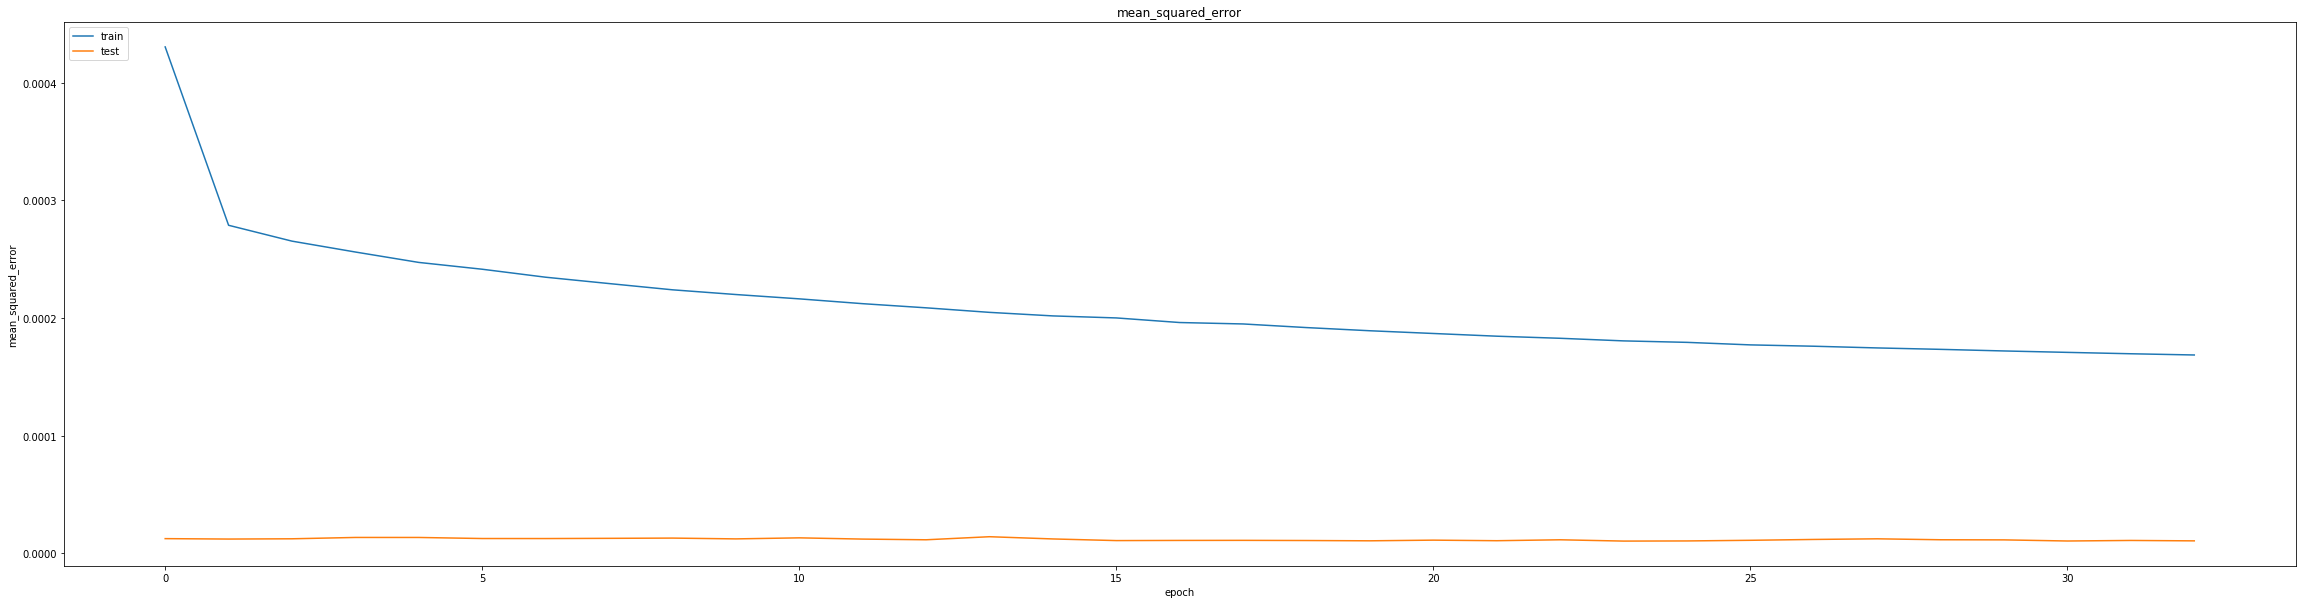

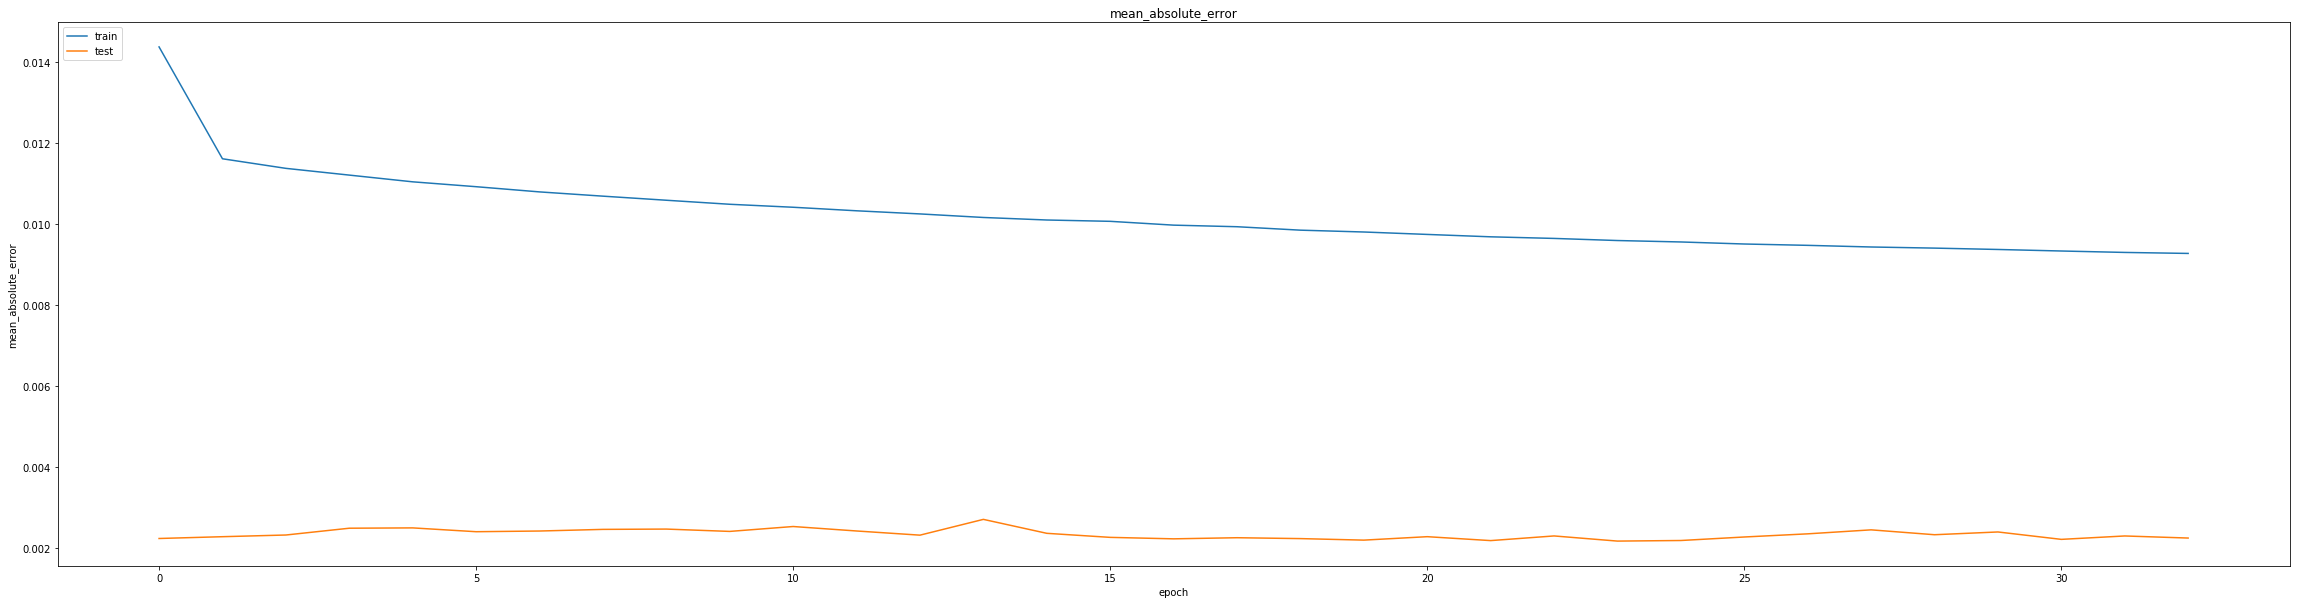

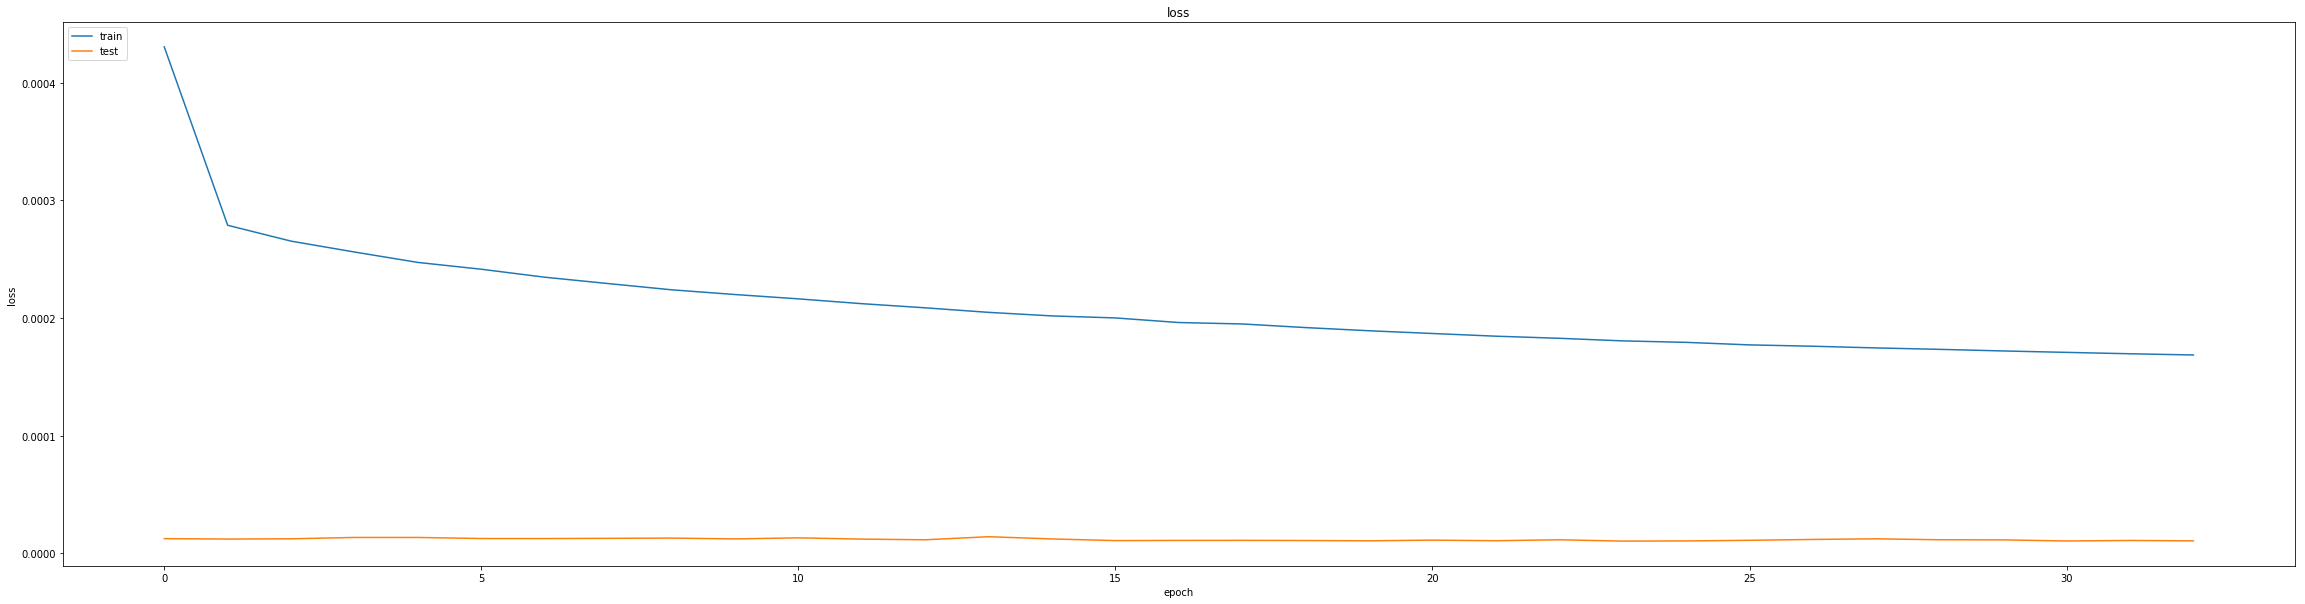

In [39]:
epoch = len(history.history['loss'])
for k in list(history.history.keys()):
    if 'val' not in k:
        plt.figure(figsize=(40,10))
        plt.plot(history.history[k])
        plt.plot(history.history['val_' + k])
        plt.title(k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()


In [40]:
min(history.history['val_mean_absolute_error'])

0.0021724022948290786

The variance should have improved slightly. However, unless the mean absolute error is not small enough. The model is still not an usable model in practice. This is mainly due to only using the sample data for training and limiting epoch to a few hundreds.


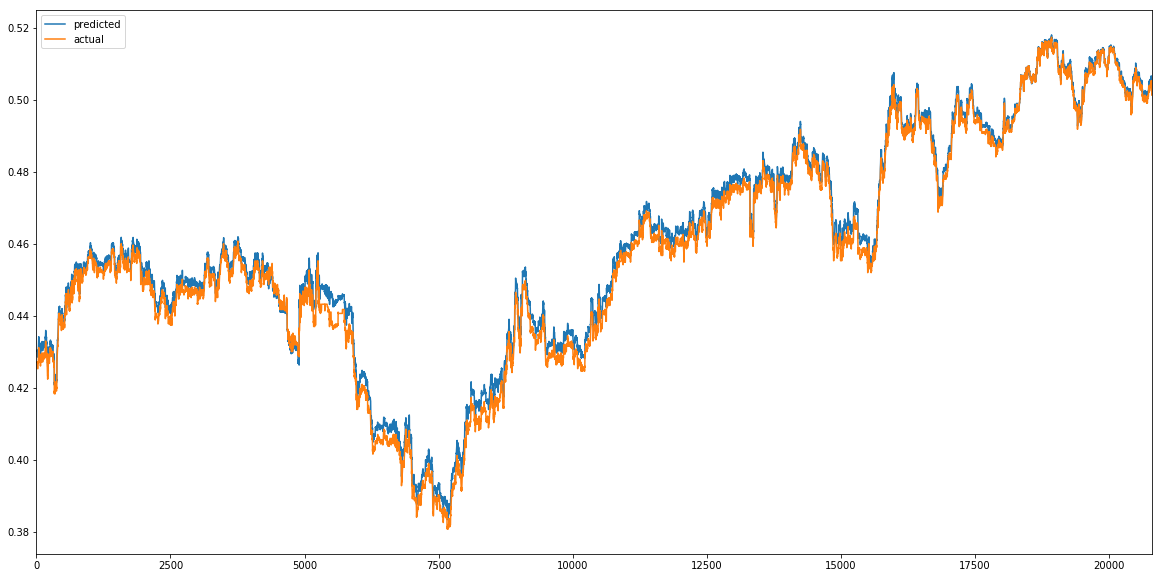

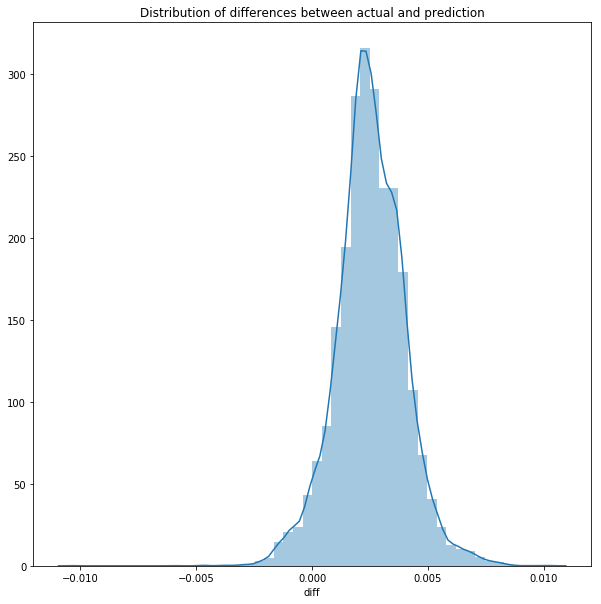

MSE :  8.5686068097e-06
MAE :  0.00260148191793


count    20817.000000
mean         0.002528
std          0.001476
min         -0.010324
25%          0.001668
50%          0.002496
75%          0.003467
max          0.010337
Name: diff, dtype: float64

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Benchmark
model.load_weights(simname+".weights.best.hdf5")

pred = model.predict(testX)

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = testY
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

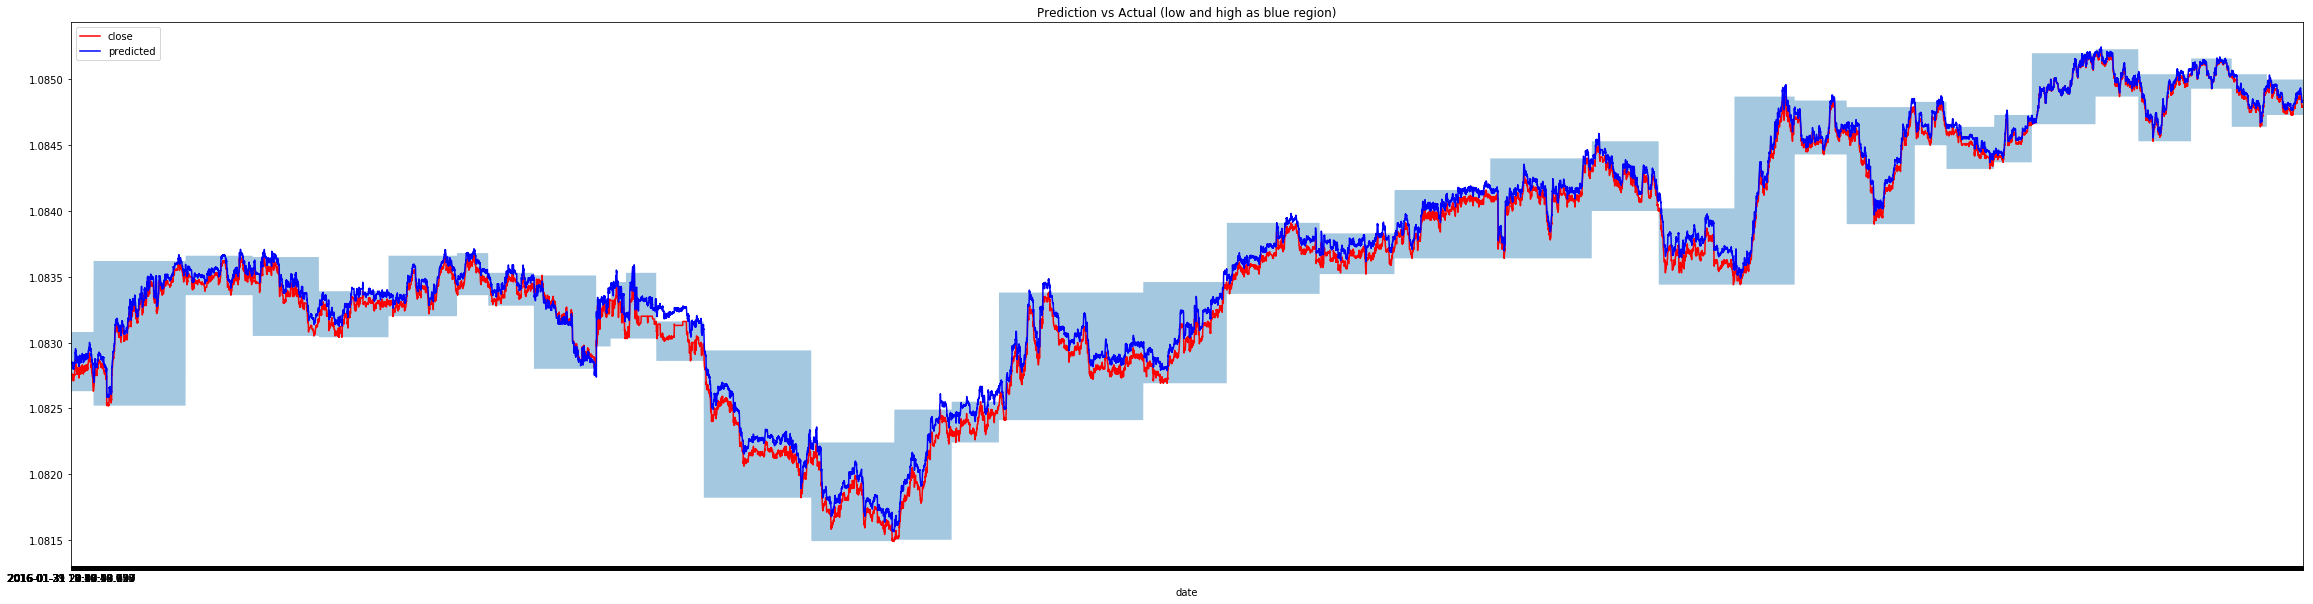

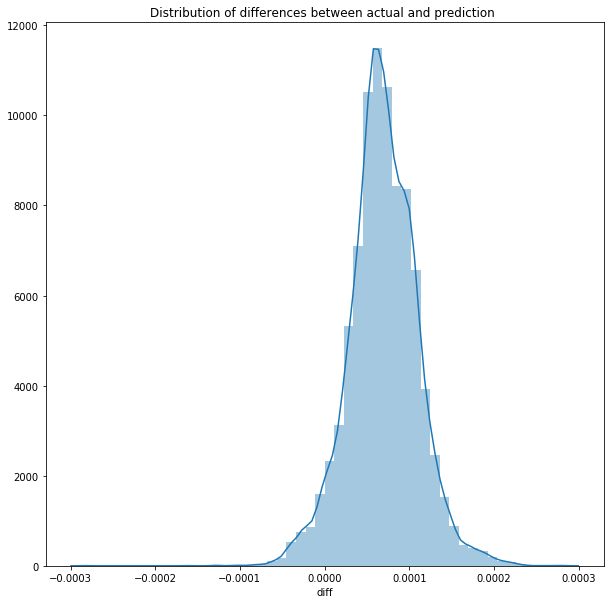

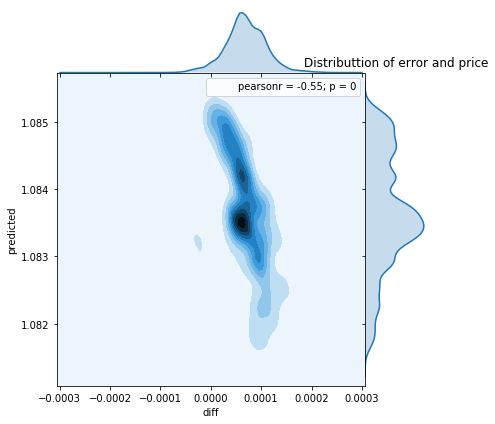

MSE :  6.42847482193e-09
MAE :  7.12554587774e-05


count    20817.000000
mean         0.000069
std          0.000040
min         -0.000283
25%          0.000046
50%          0.000068
75%          0.000095
max          0.000283
Name: diff, dtype: float64

In [42]:
pred = model.predict(testX)
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))
predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

p = df[-pred.shape[0]:].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low', 'high']], right_index=True, left_index=True)

ax = predictions.plot(x=predictions.index, y='close', c='red', figsize=(40,10))
ax = predictions.plot(x=predictions.index, y='predicted', c='blue', figsize=(40,10), ax=ax)
index = [str(item) for item in predictions.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['close']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

g = sns.jointplot("diff", "predicted", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

# predictions['correct'] = (predictions['predicted'] <= predictions['high']) & (predictions['predicted'] >= predictions['low'])
# sns.factorplot(data=predictions, x='correct', kind='count')

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
predictions['diff'].describe()
